# Building and training a Multi Layered Perceptron (MLP) using Tensorflow

In this workbook we will use the python library Tensorflow to implement an MLP. We will implement MLPs for classification as a way of dipping into Tensorflow. We will also cover considerations for training such as batch sizes and learning rates as well as ways to avoid overfitting. We will also looking at the training loss output as well as saving and loading models 

To run a code cell, click on the cell the press "Shift + Enter"

### Import required libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import cm

#Want to use version of Tensorflow > 2.0
print('Using Tensorflow version %s' % tf.__version__)


Using Tensorflow version 2.3.0


### Create the data

Let's generate a dataset, consisting of two data types which we call signal and background. Each data type is normally generated around a point in the x-y plane. Distinguishing signal from backgorund in this case is a very simple problem. You could use PDFs and likelihoods to identify signal and backgound. However for the purpose of this tutorial we will build a very simply MLP classifier to identify events as signal or background

In [3]:
#Create datasets
num_events = 10000

#Signal x and y mean values
signal_mean = [1.0, 1.0]
#Signal x and y values are uncorrelated
signal_cov = [[1.0, 0.0],
              [0.0, 1.0]]

#Generate a training and validation sample
signal_train = np.random.multivariate_normal(
        signal_mean, signal_cov, num_events)
signal_val = np.random.multivariate_normal(
        signal_mean, signal_cov, num_events)

#Background x and y mean values
background_mean = [-1.0, -1.0]
#Background x and y values are uncorrelated
background_cov = [[1.0, 0.0],
                  [0.0, 1.0]]

#Generate a training and validation sample
background_train = np.random.multivariate_normal(
        background_mean, background_cov, num_events)
background_val = np.random.multivariate_normal(
        background_mean, background_cov, num_events)

#Add the signal and background samples
data_train = np.vstack([signal_train, background_train])
labels_train = np.vstack([np.ones((num_events, 1)), np.zeros((num_events, 1))])

#Add the signal and background samples
data_val = np.vstack([signal_val, background_val])
labels_val = np.vstack([np.ones((num_events, 1)), np.zeros((num_events, 1))])

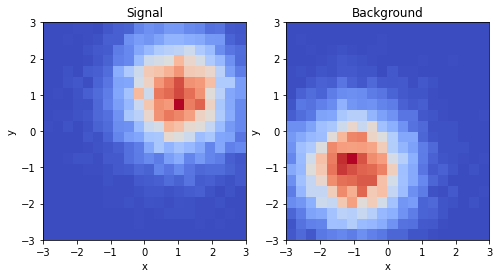

In [4]:
#Plot the datasets generated
range_ = ((-3, 3), (-3, 3))
plt.figure(0, figsize=(8,4))
plt.subplot(1,2,1); plt.title("Signal")
plt.xlabel("x"), plt.ylabel("y")
plt.hist2d(signal_train[:,0], signal_train[:,1],
        range=range_, bins=20, cmap=cm.coolwarm)
plt.subplot(1,2,2); plt.title("Background")
plt.hist2d(background_train[:,0], background_train[:,1],
        range=range_, bins=20, cmap=cm.coolwarm)
plt.xlabel("x"), plt.ylabel("y");

Because this is a simple problem we can build a simple MLP to identify signal and background events 

An MLP consists of at least three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that can use a nonlinear activation function


![title](images/mlp.png)

In [13]:
# Let's use Tensorflows sequential API. We pass the layers to the API sequentially
#Construct Neural Net

model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation="relu", input_dim=2))
model.add(keras.layers.Dense(1, activation="sigmoid"))

It is useful to look at the architecture of your neural net to check it makes sense. Do you have the total number of parameters you would expect to have. 

Expected number of parameters: each input is connected to a node in the first hidden layer by a weight. So that is 2 inputs connected to 100 nodes = 200 weights. Each node has a bias, so 100 biases. Therefore that is 200 weights + 100 biases = 300 parameters at the first layer

The 100 nodes are connected to 1 ouput node, so that is 100 weights. The output node has a bias to the number of parameters here is 100. Therefore the total number of parameters required to construct this neural net is 401

Use the model's method .summary() to see a breakdown of your neural net

In [14]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


Set loss function and optimiser. As this is a classification neural net we want to use binary cross entropy as the loss function. We will use Adam as the optimiser. The Adam optimiser is based on gradient decent but has a more sophisticated adaption of learning rates for parameters

In [15]:
# Set loss function and optimiser
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


Train on data. Define the dataset you want to train on and the validation set you want to validate the training against. Set the number of epochs (the number of iterations over the dataset). Set the batch size. This is a number/size of events smaller than your dataset that you run over and update the weights of your neural net. You run over multiples of batch sizes until you have run over all your events in your dataset. That is one epoch.  The batch size can actually be quite important. The main benefit of large batch sizes is that the training algorithm will see more instances per calculation. If you have the hardware large batch sizes are usually recommended. However large batch sizes can lead to instabilities. Particularly at the start of trainin.  A small batch size can be good if you are low on computer memory or want to avoid getting stuck in a local minima. Too small a batch size can make converging on optimal weighs slow!

In [16]:
num_epochs = 100
#Not worried about memory or local minima
batchSize = len(data_train)

#Train on data
history = model.fit(data_train, labels_train,
          validation_data=(data_val, labels_val),
          batch_size=batchSize,
          epochs=num_epochs)


Epoch 1/200
1/1 [==============================] - 0s 423ms/step - loss: 0.6399 - accuracy: 0.7311 - val_loss: 0.6290 - val_accuracy: 0.7882
Epoch 2/200
1/1 [==============================] - 0s 128ms/step - loss: 0.6289 - accuracy: 0.7908 - val_loss: 0.6183 - val_accuracy: 0.8740
Epoch 3/200
1/1 [==============================] - 0s 178ms/step - loss: 0.6182 - accuracy: 0.8762 - val_loss: 0.6077 - val_accuracy: 0.8782
Epoch 4/200
1/1 [==============================] - 0s 202ms/step - loss: 0.6077 - accuracy: 0.8804 - val_loss: 0.5974 - val_accuracy: 0.8831
Epoch 5/200
1/1 [==============================] - 0s 194ms/step - loss: 0.5974 - accuracy: 0.8838 - val_loss: 0.5872 - val_accuracy: 0.8857
Epoch 6/200
1/1 [==============================] - 0s 200ms/step - loss: 0.5872 - accuracy: 0.8871 - val_loss: 0.5773 - val_accuracy: 0.8885
Epoch 7/200
1/1 [==============================] - 0s 168ms/step - loss: 0.5773 - accuracy: 0.8894 - val_loss: 0.5675 - val_accuracy: 0.8916
Epoch 8/200
1

Epoch 59/200
1/1 [==============================] - 0s 147ms/step - loss: 0.2860 - accuracy: 0.9200 - val_loss: 0.2835 - val_accuracy: 0.9172
Epoch 60/200
1/1 [==============================] - 0s 203ms/step - loss: 0.2834 - accuracy: 0.9202 - val_loss: 0.2810 - val_accuracy: 0.9174
Epoch 61/200
1/1 [==============================] - 0s 180ms/step - loss: 0.2809 - accuracy: 0.9203 - val_loss: 0.2786 - val_accuracy: 0.9176
Epoch 62/200
1/1 [==============================] - 0s 157ms/step - loss: 0.2785 - accuracy: 0.9204 - val_loss: 0.2763 - val_accuracy: 0.9175
Epoch 63/200
1/1 [==============================] - 0s 213ms/step - loss: 0.2762 - accuracy: 0.9203 - val_loss: 0.2740 - val_accuracy: 0.9175
Epoch 64/200
1/1 [==============================] - 0s 201ms/step - loss: 0.2739 - accuracy: 0.9204 - val_loss: 0.2718 - val_accuracy: 0.9175
Epoch 65/200
1/1 [==============================] - 0s 286ms/step - loss: 0.2716 - accuracy: 0.9207 - val_loss: 0.2696 - val_accuracy: 0.9174
Epoch 

1/1 [==============================] - 0s 125ms/step - loss: 0.2117 - accuracy: 0.9219 - val_loss: 0.2117 - val_accuracy: 0.9201
Epoch 117/200
1/1 [==============================] - 0s 187ms/step - loss: 0.2112 - accuracy: 0.9220 - val_loss: 0.2112 - val_accuracy: 0.9201
Epoch 118/200
1/1 [==============================] - 0s 142ms/step - loss: 0.2107 - accuracy: 0.9222 - val_loss: 0.2107 - val_accuracy: 0.9201
Epoch 119/200
1/1 [==============================] - 0s 188ms/step - loss: 0.2102 - accuracy: 0.9222 - val_loss: 0.2103 - val_accuracy: 0.9201
Epoch 120/200
1/1 [==============================] - 0s 174ms/step - loss: 0.2097 - accuracy: 0.9222 - val_loss: 0.2098 - val_accuracy: 0.9203
Epoch 121/200
1/1 [==============================] - 0s 154ms/step - loss: 0.2092 - accuracy: 0.9223 - val_loss: 0.2093 - val_accuracy: 0.9201
Epoch 122/200
1/1 [==============================] - 0s 116ms/step - loss: 0.2088 - accuracy: 0.9223 - val_loss: 0.2089 - val_accuracy: 0.9202
Epoch 123/200

1/1 [==============================] - 0s 156ms/step - loss: 0.1964 - accuracy: 0.9222 - val_loss: 0.1970 - val_accuracy: 0.9213
Epoch 174/200
1/1 [==============================] - 0s 186ms/step - loss: 0.1963 - accuracy: 0.9222 - val_loss: 0.1969 - val_accuracy: 0.9213
Epoch 175/200
1/1 [==============================] - 0s 171ms/step - loss: 0.1961 - accuracy: 0.9222 - val_loss: 0.1968 - val_accuracy: 0.9212
Epoch 176/200
1/1 [==============================] - 0s 214ms/step - loss: 0.1960 - accuracy: 0.9222 - val_loss: 0.1967 - val_accuracy: 0.9212
Epoch 177/200
1/1 [==============================] - 0s 181ms/step - loss: 0.1959 - accuracy: 0.9222 - val_loss: 0.1966 - val_accuracy: 0.9212
Epoch 178/200
1/1 [==============================] - 0s 131ms/step - loss: 0.1958 - accuracy: 0.9223 - val_loss: 0.1965 - val_accuracy: 0.9212
Epoch 179/200
1/1 [==============================] - 0s 151ms/step - loss: 0.1958 - accuracy: 0.9224 - val_loss: 0.1964 - val_accuracy: 0.9212
Epoch 180/200

92% accurracy. Not bad! Be careful with accuracy measurments. It is easy to measure high accuracy if your validation or test sample mainly has one category of data. Not the case here!

Plot the loss of the neural net as a function of epoch

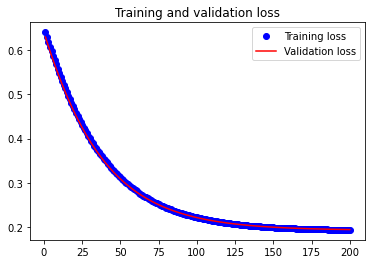

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

What about saving the model. Also at what point do save the model. This is an ideal example where the loss is smooth and decreases monotonically. You'll find this is rarely the case. What I tend to do is save the model each time the validation loss reaches a minimum. You overtrain your neural net if you use the training loss as a metric for saving your model. Let's use a callback to save the model. A callback kets you specify a list of objects that will be called during training. We can use a callback to save the model every time the validation loss is at a minimum

In [18]:
import os

#Specify a directory to save model

model_filename = 'simple_mlp.h5'
saved_model_directory = 'models'

checkpoint_filename = os.path.join(saved_model_directory, model_filename)

CHECK_FOLDER = os.path.isdir(saved_model_directory)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(saved_model_directory)
    print("created folder : ", saved_model_directory)
                
#Create checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filename,
        monitor='val_loss',
        save_weights_only=True,
        save_best_only=True,
        verbose = 1)

        
history = model.fit(data_train, labels_train,
        validation_data=(data_val, labels_val),
        batch_size=len(data_train),
        epochs=num_epochs,
        callbacks=[model_checkpoint_callback])

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9224
Epoch 00001: val_loss improved from inf to 0.19501, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 240ms/step - loss: 0.1942 - accuracy: 0.9224 - val_loss: 0.1950 - val_accuracy: 0.9212
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9224
Epoch 00002: val_loss improved from 0.19501 to 0.19496, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 125ms/step - loss: 0.1942 - accuracy: 0.9224 - val_loss: 0.1950 - val_accuracy: 0.9212
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9225
Epoch 00003: val_loss improved from 0.19496 to 0.19492, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 207ms/step - loss: 0.1941 - accuracy: 0.9225 - val_loss: 0.1949 - val_accuracy: 0.9211
Epoch 4/200
1/1 [==============================] - ETA: 0s 

Epoch 27/200
1/1 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.9225
Epoch 00027: val_loss improved from 0.19418 to 0.19416, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 146ms/step - loss: 0.1933 - accuracy: 0.9225 - val_loss: 0.1942 - val_accuracy: 0.9212
Epoch 28/200
1/1 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.9225
Epoch 00028: val_loss improved from 0.19416 to 0.19414, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 147ms/step - loss: 0.1933 - accuracy: 0.9225 - val_loss: 0.1941 - val_accuracy: 0.9211
Epoch 29/200
1/1 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.9225
Epoch 00029: val_loss improved from 0.19414 to 0.19412, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 139ms/step - loss: 0.1933 - accuracy: 0.9225 - val_loss: 0.1941 - val_accuracy: 0.9211
Epoch 30/200
1/1 [==============================] - 

Epoch 53/200
1/1 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9226
Epoch 00053: val_loss improved from 0.19378 to 0.19377, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 160ms/step - loss: 0.1929 - accuracy: 0.9226 - val_loss: 0.1938 - val_accuracy: 0.9208
Epoch 54/200
1/1 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9226
Epoch 00054: val_loss improved from 0.19377 to 0.19376, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 179ms/step - loss: 0.1928 - accuracy: 0.9226 - val_loss: 0.1938 - val_accuracy: 0.9208
Epoch 55/200
1/1 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9226
Epoch 00055: val_loss improved from 0.19376 to 0.19375, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 207ms/step - loss: 0.1928 - accuracy: 0.9226 - val_loss: 0.1937 - val_accuracy: 0.9208
Epoch 56/200
1/1 [==============================] - 

Epoch 79/200
1/1 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.9226
Epoch 00079: val_loss improved from 0.19359 to 0.19358, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 190ms/step - loss: 0.1926 - accuracy: 0.9226 - val_loss: 0.1936 - val_accuracy: 0.9210
Epoch 80/200
1/1 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.9226
Epoch 00080: val_loss improved from 0.19358 to 0.19358, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 204ms/step - loss: 0.1926 - accuracy: 0.9226 - val_loss: 0.1936 - val_accuracy: 0.9210
Epoch 81/200
1/1 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.9226
Epoch 00081: val_loss improved from 0.19358 to 0.19357, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 186ms/step - loss: 0.1926 - accuracy: 0.9226 - val_loss: 0.1936 - val_accuracy: 0.9210
Epoch 82/200
1/1 [==============================] - 

Epoch 105/200
1/1 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9226
Epoch 00105: val_loss improved from 0.19349 to 0.19349, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 193ms/step - loss: 0.1925 - accuracy: 0.9226 - val_loss: 0.1935 - val_accuracy: 0.9208
Epoch 106/200
1/1 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9226
Epoch 00106: val_loss improved from 0.19349 to 0.19349, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 162ms/step - loss: 0.1925 - accuracy: 0.9226 - val_loss: 0.1935 - val_accuracy: 0.9208
Epoch 107/200
1/1 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9226
Epoch 00107: val_loss improved from 0.19349 to 0.19349, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 127ms/step - loss: 0.1925 - accuracy: 0.9226 - val_loss: 0.1935 - val_accuracy: 0.9208
Epoch 108/200
1/1 [==============================

Epoch 131/200
1/1 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9226
Epoch 00131: val_loss improved from 0.19344 to 0.19344, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 181ms/step - loss: 0.1925 - accuracy: 0.9226 - val_loss: 0.1934 - val_accuracy: 0.9205
Epoch 132/200
1/1 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9226
Epoch 00132: val_loss improved from 0.19344 to 0.19344, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 215ms/step - loss: 0.1924 - accuracy: 0.9226 - val_loss: 0.1934 - val_accuracy: 0.9205
Epoch 133/200
1/1 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9226
Epoch 00133: val_loss improved from 0.19344 to 0.19344, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 175ms/step - loss: 0.1924 - accuracy: 0.9226 - val_loss: 0.1934 - val_accuracy: 0.9205
Epoch 134/200
1/1 [==============================

Epoch 157/200
1/1 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9224
Epoch 00157: val_loss improved from 0.19341 to 0.19340, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 207ms/step - loss: 0.1924 - accuracy: 0.9224 - val_loss: 0.1934 - val_accuracy: 0.9206
Epoch 158/200
1/1 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9224
Epoch 00158: val_loss improved from 0.19340 to 0.19340, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 149ms/step - loss: 0.1924 - accuracy: 0.9224 - val_loss: 0.1934 - val_accuracy: 0.9206
Epoch 159/200
1/1 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9224
Epoch 00159: val_loss improved from 0.19340 to 0.19340, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 196ms/step - loss: 0.1924 - accuracy: 0.9224 - val_loss: 0.1934 - val_accuracy: 0.9206
Epoch 160/200
1/1 [==============================

Epoch 183/200
1/1 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9222
Epoch 00183: val_loss improved from 0.19338 to 0.19338, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 172ms/step - loss: 0.1924 - accuracy: 0.9222 - val_loss: 0.1934 - val_accuracy: 0.9207
Epoch 184/200
1/1 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9222
Epoch 00184: val_loss improved from 0.19338 to 0.19338, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 139ms/step - loss: 0.1924 - accuracy: 0.9222 - val_loss: 0.1934 - val_accuracy: 0.9207
Epoch 185/200
1/1 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9222
Epoch 00185: val_loss improved from 0.19338 to 0.19337, saving model to models/simple_mlp.h5
1/1 [==============================] - 0s 169ms/step - loss: 0.1924 - accuracy: 0.9222 - val_loss: 0.1934 - val_accuracy: 0.9207
Epoch 186/200
1/1 [==============================

Notice your model continues learning from its previous parameters! Makes sense, you haven't rest the model parameters from the last training iteration

### Load a saved model

Now we have saved the parameters we can load them at any time

In [19]:
#Load model

model.load_weights(checkpoint_filename)


## Image classification with a MLP

We can look at the MNIST dataset, famous in machine learning examples. Specifically we can look at images of handwritten numbers 0-9 and use a MLP to identify them. This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the <a id='http://yann.lecun.com/exdb/mnist'>MNIST homepage</a>.

Image label is: 5


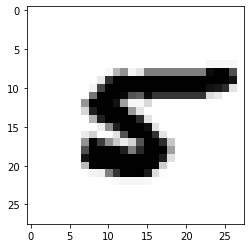

In [20]:
#Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


# Randomly look at one of the images
random_ints =np.random.randint(len(x_test), size=1)
image_index = random_ints[0]

plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')

print('Image label is: %i' % y_test[image_index])


Let's build an mlp to identify the images. The intenstiy of the pixels is represented as a value from 0 to 255. We should normalise the intensity. Also, the image is a 2D array so we should flatten it to a 1D array so the values can be input into a MLP. Lets build a simple MLP with a hidden layer containing 128 nodes and an output layer of 10 nodes. Again we can work out how many parameters it would take to build this mlp. 

The total number of inputs required for the mlp is (an input for each pixel) 28 x 28  = 784
Total number of weights to connect each input to each node in the first layer is 784 x 128 = 100352
Total number of biases in the first layer is 128.

Total number of parameters for the first layer is = 100352 + 128 = 100480

Total number of parameters for the outut layer is = number of weights + biases = (128 * 10) + 10 = 1290

Total number of parametes =  101770

In [21]:
# Intensity of pixels ranges from 0-255. We need to normalise them
x_train, x_test = x_train / 255.0, x_test / 255.0


#Rather than instantiate the node and use the .add method to keep adding input,layers, outputs, etc we can just state
#components separated by a comma during instantiation

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


One would expect some kind of sigmoid activation function to be applied to the output. However we let the loss function SparseCategoricalCrossentropy take the output and use it to calculate the loss to best attribute probabilities to each output

In [22]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])


Train the model!

In [23]:
# Intensity of pixels ranges from 0-255. We need to normalise them
x_train, x_test = x_train / 255.0, x_test / 255.0

#Split into training and validation samples
x_train, x_val = x_train[0:55000], x_train[55000:]
y_train, y_val = y_train[0:55000], y_train[55000:]

In [24]:
num_epochs = 10
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=num_epochs)

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 1.2136 - accuracy: 0.6999 - val_loss: 0.5543 - val_accuracy: 0.8768
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5125 - accuracy: 0.8655 - val_loss: 0.3549 - val_accuracy: 0.9134
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4015 - accuracy: 0.8895 - val_loss: 0.3001 - val_accuracy: 0.9232
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3575 - accuracy: 0.8992 - val_loss: 0.2705 - val_accuracy: 0.9256
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3328 - accuracy: 0.9053 - val_loss: 0.2518 - val_accuracy: 0.9306
Epoch 6/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3164 - accuracy: 0.9096 - val_loss: 0.2404 - val_accuracy: 0.9334
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3036 - accuracy: 0.9131 - val_loss: 0.2313 - val_a

Greater than 90%, pretty good! With a more complex mlp and more epochs you can do much better!

## Learning Rate Scheduling

Finiding a good rate is very import. Too large a learning rate and your training my never converge. Too low and training can take forever to converge. One has to find an optimal learning rate. Or even better, you don't need to have a constant learning rate. You can start with a large learning rate and then as soon as the training stops making fast progress you can reduce the learning rate. You can use what is called a learning rate scheduler to define the learning rate as a function of epoch. The learning rate scheduler can be passed to the fit function as a callback 

## Power Scheduling

lr = lr0 /(1 + (epoch / s))

In [ ]:
# Learning rate lr0 drops by 1/2, 1/3, 1/4 .. after s steps
def power_decay(lr0, s):
    def power_decay_function(epoch):
        return lr0/(1 + (epoch / s))
    return power_decay_function

power_decay_fn = power_decay(0.01,20)

lr_scheduler = keras.callbacks.LearningRateScheduler(power_decay_fn)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
             
num_epochs = 10
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=num_epochs, callbacks=[lr_scheduler])

### Exponential Scheduling

<mrow>lr = lr0 * 0.1**(epoch / s)</mrow>

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
             
num_epochs = 10
hisotry = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=num_epochs, callbacks=[lr_scheduler])


### Piecewise Constant Sheduling

With piecewise constant sheduling you can set a fixed learning rate for different epoch ranges.Most of the time I find piecewise sheduling simple and effective enough to acheive what I want 

In [ ]:
##Two implementations for piecewise constant sheduling
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001
    
    
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
             
num_epochs = 10
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=num_epochs, callbacks=[lr_scheduler])

### Avoiding Overfiiting through dropout

In [ ]:
def generate_data(num_events):
    noise, scale  = np.random.rand(2, num_events)
    #Generate x values
    x = scale * np.pi *2
    #Generate y values
    y = np.sin (1.2*x - 1.5) + (0.8* noise)
    return x , y

data_x, data_y  = generate_data(45)

i1 = 15
i2 = 30

x_train , x_val, x_test = data_x[0:i1], data_x[i1:i2], data_x[i2:]
y_train, y_val, y_test = data_y[0:i1], data_y[i1:i2], data_y[i2:]


plt.plot(x_train, y_train, 'o')


Create a simple MLP to model the distribution. This is regression so no use of the sigmoid activation function on the output. Also we will use a different loss function, say mean squared error

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(64, activation="relu", input_dim=1))
model.add(keras.layers.Dense(32, activation="relu", input_dim=1))
model.add(keras.layers.Dense(1, ))

model.summary()




In [ ]:
model.compile(optimizer='adam',
              loss='mse')
             
    
piecewise_constant_fn = piecewise_constant([100, 150, 300], [0.01, 0.0075, 0.005, 0.002])

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)  
    
num_epochs = 500
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=num_epochs, callbacks=[lr_scheduler])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
y_train_prediction = model.predict(x_train)
#Change the shape of data (make it 1D)
y_train_prediction = np.squeeze(y_train_prediction)

In [ ]:
# Compare estimation with truth

plt.plot(x_train, y_train, 'o')
plt.plot(x_train, y_train_prediction, 'o', color='red')

In [ ]:
y_test_prediction = model.predict(x_test)
#Change the shape of data (make it 1D)
y_test_prediction = np.squeeze(y_test_prediction)

In [ ]:
# Compare estimation with truth

plt.plot(x_test, y_test, 'o')
plt.plot(x_test, y_test_prediction, 'o', color='red')